In [1]:
from torch.utils.data import Dataset, DataLoader# For custom data-sets
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import torch
import pandas as pd
from collections import namedtuple
import random

n_class = 27

# a label and all meta information
Label = namedtuple( 'Label' , [
    'name'        , 
    'level3Id'    , 
    'color'       , 
    ] )

labels = [
    #       name                     level3Id  color
    Label(  'road'                 ,    0  , (128, 64,128)  ),
    Label(  'drivable fallback'    ,    1  , ( 81,  0, 81)  ),
    Label(  'sidewalk'             ,    2  , (244, 35,232)  ),
    Label(  'non-drivable fallback',    3  , (152,251,152)  ),
    Label(  'person/animal'        ,    4  , (220, 20, 60)  ),
    Label(  'rider'                ,    5  , (255,  0,  0)  ),
    Label(  'motorcycle'           ,    6  , (  0,  0,230)  ),
    Label(  'bicycle'              ,   7  , (119, 11, 32)  ),
    Label(  'autorickshaw'         ,   8  , (255, 204, 54) ),
    Label(  'car'                  ,   9  , (  0,  0,142)  ),
    Label(  'truck'                ,  10 ,  (  0,  0, 70)  ),
    Label(  'bus'                  ,  11 ,  (  0, 60,100)  ),
    Label(  'vehicle fallback'     ,  12 ,  (136, 143, 153)),  
    Label(  'curb'                 ,   13 ,  (220, 190, 40)),
    Label(  'wall'                 ,  14 ,  (102,102,156)  ),
    Label(  'fence'                ,  15 ,  (190,153,153)  ),
    Label(  'guard rail'           ,  16 ,  (180,165,180)  ),
    Label(  'billboard'            ,   17 ,  (174, 64, 67) ),
    Label(  'traffic sign'         ,  18 ,  (220,220,  0)  ),
    Label(  'traffic light'        ,  19 ,  (250,170, 30)  ),
    Label(  'pole'                 ,  20 ,  (153,153,153)  ),
    Label(  'obs-str-bar-fallback' , 21 ,  (169, 187, 214) ),  
    Label(  'building'             ,  22 ,  ( 70, 70, 70)  ),
    Label(  'bridge/tunnel'        ,  23 ,  (150,100,100)  ),
    Label(  'vegetation'           ,  24 ,  (107,142, 35)  ),
    Label(  'sky'                  ,  25 ,  ( 70,130,180)  ),
    Label(  'unlabeled'            ,  26 ,  (  0,  0,  0)  ),
]   

class IddDataset(Dataset):

    def __init__(self, csv_file, n_class=n_class, transforms_=None):
        self.data      = pd.read_csv(csv_file)
        self.n_class   = n_class
        self.mode = csv_file
        self.do_transform = False
        
        #For 4a
        if transforms_==True: #Augmenting the training dataset. Should be "True" only when we call train_dataloader.
            frames = [self.data,self.data]
            result = pd.concat(frames)
            self.data = result
            self.do_transform = True 
        
        # Add any transformations here
        self.resize_transform = transforms.Resize((256, 256))
        # The following transformation normalizes each channel using the mean and std provided
        self.transforms = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        img = Image.open(img_name).convert('RGB')
        label_name = self.data.iloc[idx, 1]
        label = Image.open(label_name)
        #print("Img type is {}".format(type(img)))
        
        #do any one transformation randomly, 
        if self.do_transform:
            #print("Applying transformation...")
           #there will be 2 copies of each image. 
            # So each copy will be transformed randomly.
            transform_type = random.randint(0,2)
            
            if transform_type==0:
                #using mirror flip
                img = transforms.functional.hflip(img)
                label = transforms.functional.hflip(label)

            elif transform_type==1:
                #rotating the image 
                rotate_transform = transforms.RandomRotation(30) 
                img = rotate_transform(img)
                label = rotate_transform(label)

            else:
                #different crops 
                #self.resize_transform = transforms.RandomResizedCrop(((256,256))) 
                crop_transform = transforms.RandomCrop(((256,512))) 
                img = crop_transform(img)
                label = crop_transform(label)
                
        #resize your input images such that its dimensions are a power of 2
        img = self.resize_transform(img)
        label = self.resize_transform(label)
        
        img = np.asarray(img) / 255. # scaling [0-255] values to [0-1]
        label = np.asarray(label)
        # Normalization
        img = self.transforms(img).float()
        # Convert to tensor
        label = torch.from_numpy(label.copy()).long()

        # create one-hot encoding
        h, w = label.shape
        target = torch.zeros(self.n_class, h, w)
        for c in range(self.n_class):
            target[c][label == c] = 1
        return img, target, label


In [2]:
train_dataset = IddDataset(csv_file='train.csv',transforms_=True)
val_dataset = IddDataset(csv_file='val.csv')
test_dataset = IddDataset(csv_file='test.csv')


train_loader = DataLoader(dataset=train_dataset, batch_size= 3, num_workers=4, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size= 3, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size= 3, num_workers=4, shuffle=False)

In [3]:
print(len(train_dataset),train_loader.__len__())
print(len(val_dataset))
print(len(test_dataset))

8036 2679
2009
1004


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'> torch.Size([3, 256, 256])


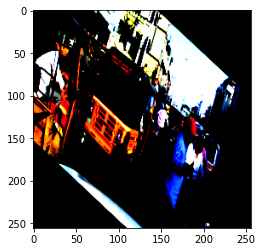

In [4]:
import matplotlib.pyplot as plt
# Print the shape of the training dataset
#print(train_dataset[0][0].shape)
# Permute the object into a different shape
idx = 0
train_image = train_dataset.__getitem__(idx)
print(type(train_image[idx]),train_image[idx].shape)
tensor_image = train_image[idx]
# print(type(tensor_image), tensor_image.shape)
plt.imshow(tensor_image.permute(1, 2, 0))
# plt.imshow(test_image.permute(1, 2, 0))
# plt.imshow(val_image.permute(1, 2, 0))

In [5]:
class dice_coefficient_loss(torch.nn.Module):
    def init(self):
        super(dice_coefficient_loss, self).init()
        
    def forward(self,pred, target):
        # skip the batch and class axis for calculating Dice score (bxcx......)
        axes = tuple(range(2, len(pred.shape))) 
        #we can approximate |A∩B| as the element-wise multiplication between the prediction and target, and then sum the resulting matrix.
        #common activations between our prediction and target
        numerator = 2 * torch.sum(pred * target,axes) 
        #quantity of activations in pred & target separately
        denominator = torch.sum((pred*pred) + (target*target),axes)
        #formulate a loss function which can be minimized, we'll simply use 1−Dice, same effect as normalizing loss
        return 1 - torch.mean((numerator + 1e-6) / (denominator + 1e-6)) 

In [6]:
from torchvision import utils
from basic_fcn import *
#from dataloader import *
from utils import *
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time
import pandas as pd 
from collections import defaultdict

# First read the dataset
train_dataset = IddDataset(csv_file='train.csv',transforms_=True)
val_dataset = IddDataset(csv_file='val.csv')
test_dataset = IddDataset(csv_file='test.csv')

# train_loader, val_loader and test_loader are three different sets of data
train_loader = DataLoader(dataset=train_dataset, batch_size= 6, num_workers=4, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size= 6, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size= 6, num_workers=4, shuffle=False)

print("Train dataset size = ",len(train_dataset))
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        #torch.nn.init.xavier_uniform(m.weight.data)
        torch.nn.init.xavier_uniform_(m.weight.data)
        #print("Dimension of weight = {}".format(m.weight.shape))
        #print("Dimension of bias = {}".format(m.bias.shape))
        #torch.nn.init.xavier_uniform(m.bias.data)
        torch.nn.init.zeros_(m.bias.data)

        
        
MODEL_NAME = 'best_model_4a'        
epochs = 100      
criterion = dice_coefficient_loss()
#nn.CrossEntropyLoss()# Choose an appropriate loss function from https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html
fcn_model = FCN(n_class=n_class)
print("No of classes = ",n_class)
fcn_model.apply(init_weights)

optimizer = optim.Adam(fcn_model.parameters(), lr=5e-3)

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using GPU")
    fcn_model = fcn_model.cuda()

        
def train():
    print("Reached train function")
    best_loss = float('inf')
    val_loss = []
    train_loss = []
    for epoch in range(epochs):
        train_loss_batch = []
        ts = time.time()
        print("Epoch: {}".format(epoch))
        for itera, (X, tar, Y) in enumerate(train_loader):
            #print("Printing the contents of X, tar and Y")
            #print("X, tar, Y are {}, {} and {}".format(type(X), type(tar), type(Y)))
            optimizer.zero_grad()
            if use_gpu:
                inputs = X.cuda()# Move your inputs onto the gpu
                #labels = tar.long()
                train_labels = Y.cuda()# Move your labels onto the gpu
                train_targets = tar.cuda()
            else:
                inputs, train_labels,train_targets = X, Y,tar # Unpack variables into inputs and labels

            outputs = fcn_model(inputs)
            #loss = criterion(outputs, train_labels)
            predictions = F.softmax(outputs,1)
            loss = criterion(predictions,train_targets)
            loss = torch.unsqueeze(loss,0)
            loss = loss.mean()
            train_loss_batch.append(loss.item())
            loss.backward()
            optimizer.step()
            
            if itera % 100 == 0:
                print("TRAINING: epoch{}, iter{}, loss: {}".format(epoch, itera, loss.item())) 
        
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        train_loss.append(np.mean(np.array(train_loss_batch)))
        curr_val_loss, val_inputs = val(epoch)
        val_loss.append(curr_val_loss)
        if curr_val_loss<best_loss:
            print ("Saving best model after %d epochs." % (epoch))
            best_loss = curr_val_loss
            torch.save(fcn_model, MODEL_NAME)
        if epoch>=5:
            stop = 0
            for i in range(0,5):
                if val_loss[epoch-i] > val_loss[epoch-i-1]:
                    stop = stop + 1
            if stop == 5 :
                print ("EarlyStop after %d epochs." % (epoch))
                return train_loss, val_loss, val_inputs
        torch.save(fcn_model, 'last_saved_model')
        fcn_model.train()
    return train_loss, val_loss, val_inputs


def val(epoch):
    #Complete this function - Calculate loss, accuracy and IoU for every epoch
    # Make sure to include a softmax after the output from your model
    fcn_model.eval() # Don't forget to put in eval mode !
    val_loss = []
    val_iou = []
    val_acc = []
    with torch.no_grad():
        for itera, (X, tar, Y) in enumerate(val_loader):
            #print("Printing the contents of X, tar and Y")
            #print("X, tar, Y are {}, {} and {}".format(type(X), type(tar), type(Y)))
            if use_gpu:
                inputs = X.cuda()# Move your inputs onto the gpu
                #labels= tar.long()
                val_labels = Y.cuda()# Move your labels onto the gpu
                val_targets = tar.cuda()
            else:
                inputs, val_labels,val_targets = X, Y,tar#.long()# Unpack variables into inputs and labels
            outputs = fcn_model(inputs)
            #loss = criterion(outputs, val_labels)
            predictions = F.softmax(outputs,1)
            loss = criterion(predictions,val_targets)
            loss = torch.unsqueeze(loss,0)
            loss = loss.mean()
            val_loss.append(loss.item())
            if itera % 100 == 0:
                print("VALIDATION: iter{}, loss: {}".format(itera, loss.item()))
            #predictions = F.softmax(outputs,1)
            predictions = torch.argmax(predictions,dim=1)
            #print("Preds shape = ",predictions.shape) #[2, 256, 256]
            #print("Shape of Y = ",Y.shape) #[2, 256, 256]
            iou_row,avg_iou = iou(predictions,val_labels)
            val_iou.append(avg_iou)
            #print("Val acc = ",pixel_acc(predictions,Y))
            val_acc.append(pixel_acc(predictions,val_labels))
            #TODO: pass pred_one_hot,labels_one_hot for accuracy and iou calculations
        #print("Last itera's inputs size: ",len(inputs))
        #print("Last itera's target size: ",len(Y))
        #print("Last itera's prediction: ", predictions)
        #print("Last itera's accuracy: ",pixel_acc(predictions,Y))
#         val_loss = val_loss[:-1]
#         val_iou = val_iou[:-1]
#         val_acc = val_acc[:-1]
        avg_loss = np.mean(np.asarray(val_loss))
        avg_iou = np.mean(np.asarray(val_iou))
        avg_acc = np.mean(np.asarray(val_acc))
        print("Validation epoch {}: avg_iou = {}, avg_acc = {}".format(epoch,avg_iou,avg_acc))
        return avg_loss, inputs    
    
def test():
    fcn_model = torch.load(MODEL_NAME)
    fcn_model.eval()
    #Complete this function - Calculate accuracy and IoU 
    # Make sure to include a softmax after the output from your model
    val_iou = []
    val_acc = []
    val_ious_cls = []
    with torch.no_grad():
        for itera, (X, tar, Y) in enumerate(val_loader):
            #print("Printing the contents of X, tar and Y")
            #print("X, tar, Y are {}, {} and {}".format(type(X), type(tar), type(Y)))
            if use_gpu:
                inputs = X.cuda()# Move your inputs onto the gpu
                #labels= tar.long()
                test_labels = Y.cuda()# Move your labels onto the gpu
            else:
                inputs, test_labels = X,Y#.long()# Unpack variables into inputs and labels
            outputs = fcn_model(inputs)
            predictions = torch.nn.functional.softmax(outputs,1)
            # create one-hot encoding
            predictions = torch.argmax(predictions,dim=1)
            #print("Preds shape = ",predictions.shape) #[2, 256, 256]
            #print("Shape of Y = ",Y.shape) #[2, 256, 256]
            iou_row,avg_iou = iou(predictions,test_labels)
            if iou_row is not None:
                #iou_row = (iou_row).cpu().numpy()
                val_ious_cls.append(iou_row)
            val_iou.append(avg_iou)
            val_acc.append(pixel_acc(predictions,test_labels))
        #val_loss = val_loss[:-1]
#         val_iou = val_iou[:-1]
#         val_acc = val_acc[:-1]
        avg_iou = np.mean(np.asarray(val_iou))
        avg_acc = np.mean(np.asarray(val_acc))
        if iou_row is not None:
            avg_ious_cls = np.nanmean(np.asarray(val_ious_cls),axis=0) #iou for the class when it's union=0 will be nan
        print("Final test from best model : avg_iou = {}, avg_acc = {}".format(avg_iou,avg_acc))
        print(" Class wise ious getting saved in "+MODEL_NAME+"_IOU_Classwise.csv file")
        
        if iou_row is not None:
            d = []
            labels_len = len(labels)
            for idx in range(0,labels_len-1):
                 d.append((labels[idx].name, avg_ious_cls[labels[idx].level3Id]))
            df = pd.DataFrame(d, columns=('Label name', 'IoU'))
            df.to_csv(MODEL_NAME+"_IOU_Classwise.csv", sep='\t')

            test_loader = DataLoader(dataset=test_dataset, batch_size= 1, num_workers=4, shuffle=False)
            for itera, (X, tar, Y) in enumerate(test_loader):
                if use_gpu:
                    inputs = X.cuda()# Move your inputs onto the gpu
                    test_labels = Y.cuda()# Move your labels onto the gpu
                else:
                    inputs, test_labels = X, Y#.long() # Unpack variables into inputs and labels
                outputs = fcn_model(inputs)
                predictions = torch.nn.functional.softmax(outputs,1)
                predictions = torch.argmax(predictions,dim=1)
                break
            predictions = predictions.cpu().numpy()
            inputImage = inputs[0].permute(1, 2, 0).cpu().numpy()
            plt.imshow(inputImage, cmap='gray')
            plt.show()
            rows, cols = predictions.shape[1], predictions.shape[2]
            #print(labels)
            new_predictions = np.zeros((predictions.shape[1], predictions.shape[2], 3))
            for row in range(rows):
                for col in range(cols):
                    idx = int(predictions[0][row][col])
                    new_predictions[row][col][:] = np.asarray(labels[idx].color)       

            plt.imshow(inputImage, cmap='gray')
            plt.imshow(new_predictions, cmap='jet', alpha=0.5)
            fig_name = MODEL_NAME+"_Overlayed.jpg"  
            plt.savefig(fig_name)
            plt.show()


Train dataset size =  8036
No of classes =  27
Using GPU


In [7]:
def plot_loss_curves(train_loss,val_loss):
    title = "Loss "
    fig_name = MODEL_NAME+"_loss.jpg"
    x = [i for i in range(len(train_loss))]
    plt.plot(x, train_loss,label="Train Loss")
    plt.plot(x, val_loss,label="Validation Loss")
    plt.legend()
    plt.xlabel("# of epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.title(title)
    plt.savefig(fig_name)
    plt.show()

In [8]:
#val(0)  # show the accuracy before training
#tranform - 0, mirror flip
#transform - 1, rotate
#transform - 2, resizedcrop
train_loss, val_loss, val_inputs = train()
#print("Input 0 : ",val_inputs[0])
#print("Input 1 : ",val_inputs[1])
#print("Input 0 shape:",val_inputs[0].shape)
#print("Input 1 shape:",val_inputs[1].shape)

Reached train function
Epoch: 0
TRAINING: epoch0, iter0, loss: 0.9633728265762329
TRAINING: epoch0, iter100, loss: 0.9240798950195312
TRAINING: epoch0, iter200, loss: 0.927945613861084
TRAINING: epoch0, iter300, loss: 0.9300602674484253
TRAINING: epoch0, iter400, loss: 0.8755654096603394
TRAINING: epoch0, iter500, loss: 0.8991370797157288
TRAINING: epoch0, iter600, loss: 0.9463097453117371
TRAINING: epoch0, iter700, loss: 0.8611001968383789
TRAINING: epoch0, iter800, loss: 0.8776086568832397
TRAINING: epoch0, iter900, loss: 0.8788787126541138
TRAINING: epoch0, iter1000, loss: 0.8985704779624939
TRAINING: epoch0, iter1100, loss: 0.8978380560874939
TRAINING: epoch0, iter1200, loss: 0.9310212135314941
TRAINING: epoch0, iter1300, loss: 0.8735507726669312
Finish epoch 0, time elapsed 503.0627861022949
VALIDATION: iter0, loss: 0.8026032447814941
VALIDATION: iter100, loss: 0.7754031419754028
VALIDATION: iter200, loss: 0.8013245463371277
VALIDATION: iter300, loss: 0.7891312837600708
Validation

TRAINING: epoch7, iter1300, loss: 0.7556344270706177
Finish epoch 7, time elapsed 186.30001711845398
VALIDATION: iter0, loss: 0.7478243112564087
VALIDATION: iter100, loss: 0.734595775604248
VALIDATION: iter200, loss: 0.7214294672012329
VALIDATION: iter300, loss: 0.7239120006561279
Validation epoch 7: avg_iou = 0.5552925138331172, avg_acc = 0.7037228646563061
Saving best model after 7 epochs.
Epoch: 8
TRAINING: epoch8, iter0, loss: 0.7601715326309204
TRAINING: epoch8, iter100, loss: 0.8978896141052246
TRAINING: epoch8, iter200, loss: 0.8483113050460815
TRAINING: epoch8, iter300, loss: 0.8490155935287476
TRAINING: epoch8, iter400, loss: 0.8004217743873596
TRAINING: epoch8, iter500, loss: 0.8149522542953491
TRAINING: epoch8, iter600, loss: 0.7906596660614014
TRAINING: epoch8, iter700, loss: 0.7678216099739075
TRAINING: epoch8, iter800, loss: 0.815248966217041
TRAINING: epoch8, iter900, loss: 0.7717954516410828
TRAINING: epoch8, iter1000, loss: 0.8663367033004761
TRAINING: epoch8, iter1100

TRAINING: epoch15, iter400, loss: 0.8347097635269165
TRAINING: epoch15, iter500, loss: 0.8093237280845642
TRAINING: epoch15, iter600, loss: 0.8237985372543335
TRAINING: epoch15, iter700, loss: 0.9242044687271118
TRAINING: epoch15, iter800, loss: 0.8371110558509827
TRAINING: epoch15, iter900, loss: 0.8182249069213867
TRAINING: epoch15, iter1000, loss: 0.731605052947998
TRAINING: epoch15, iter1100, loss: 0.7501914501190186
TRAINING: epoch15, iter1200, loss: 0.7120130062103271
TRAINING: epoch15, iter1300, loss: 0.8576942682266235
Finish epoch 15, time elapsed 189.0800883769989
VALIDATION: iter0, loss: 0.7310858964920044
VALIDATION: iter100, loss: 0.7024759650230408
VALIDATION: iter200, loss: 0.7293789386749268
VALIDATION: iter300, loss: 0.6887891292572021
Validation epoch 15: avg_iou = 0.5757932070475905, avg_acc = 0.7221498855903967
Saving best model after 15 epochs.
Epoch: 16
TRAINING: epoch16, iter0, loss: 0.7923262119293213
TRAINING: epoch16, iter100, loss: 0.7922422885894775
TRAINING

VALIDATION: iter200, loss: 0.7147917747497559
VALIDATION: iter300, loss: 0.7272579073905945
Validation epoch 22: avg_iou = 0.5759143610498798, avg_acc = 0.7230244762861907
Epoch: 23
TRAINING: epoch23, iter0, loss: 0.7387741208076477
TRAINING: epoch23, iter100, loss: 0.8061855435371399
TRAINING: epoch23, iter200, loss: 0.8098458051681519
TRAINING: epoch23, iter300, loss: 0.7683017253875732
TRAINING: epoch23, iter400, loss: 0.7642101645469666
TRAINING: epoch23, iter500, loss: 0.7747700810432434
TRAINING: epoch23, iter600, loss: 0.8457177877426147
TRAINING: epoch23, iter700, loss: 0.8452669978141785
TRAINING: epoch23, iter800, loss: 0.796502947807312
TRAINING: epoch23, iter900, loss: 0.718874454498291
TRAINING: epoch23, iter1000, loss: 0.8432426452636719
TRAINING: epoch23, iter1100, loss: 0.8213374018669128
TRAINING: epoch23, iter1200, loss: 0.7869235277175903
TRAINING: epoch23, iter1300, loss: 0.6878145337104797
Finish epoch 23, time elapsed 192.00524640083313
VALIDATION: iter0, loss: 0.

TRAINING: epoch30, iter1100, loss: 0.8671679496765137
TRAINING: epoch30, iter1200, loss: 0.7908102869987488
TRAINING: epoch30, iter1300, loss: 0.7372580766677856
Finish epoch 30, time elapsed 186.48854994773865
VALIDATION: iter0, loss: 0.7090933322906494
VALIDATION: iter100, loss: 0.7068862318992615
VALIDATION: iter200, loss: 0.7076122164726257
VALIDATION: iter300, loss: 0.7126052379608154
Validation epoch 30: avg_iou = 0.5893470573781142, avg_acc = 0.7332692491474436
Epoch: 31
TRAINING: epoch31, iter0, loss: 0.8342054486274719
TRAINING: epoch31, iter100, loss: 0.8918938636779785
TRAINING: epoch31, iter200, loss: 0.738814115524292
TRAINING: epoch31, iter300, loss: 0.7987924218177795
TRAINING: epoch31, iter400, loss: 0.7959927320480347
TRAINING: epoch31, iter500, loss: 0.7442014813423157
TRAINING: epoch31, iter600, loss: 0.7603570818901062
TRAINING: epoch31, iter700, loss: 0.852615237236023
TRAINING: epoch31, iter800, loss: 0.8072794675827026
TRAINING: epoch31, iter900, loss: 0.69618356

TRAINING: epoch38, iter600, loss: 0.8432649374008179
TRAINING: epoch38, iter700, loss: 0.828835129737854
TRAINING: epoch38, iter800, loss: 0.7495182156562805
TRAINING: epoch38, iter900, loss: 0.6749385595321655
TRAINING: epoch38, iter1000, loss: 0.6933484077453613
TRAINING: epoch38, iter1100, loss: 0.7640780210494995
TRAINING: epoch38, iter1200, loss: 0.7384985089302063
TRAINING: epoch38, iter1300, loss: 0.6672236919403076
Finish epoch 38, time elapsed 186.55152797698975
VALIDATION: iter0, loss: 0.7291314601898193
VALIDATION: iter100, loss: 0.7055260539054871
VALIDATION: iter200, loss: 0.7203207015991211
VALIDATION: iter300, loss: 0.714377760887146
Validation epoch 38: avg_iou = 0.5876132026537141, avg_acc = 0.7320978298116086
Epoch: 39
TRAINING: epoch39, iter0, loss: 0.8282931447029114
TRAINING: epoch39, iter100, loss: 0.7353931665420532
TRAINING: epoch39, iter200, loss: 0.7887099385261536
TRAINING: epoch39, iter300, loss: 0.7624936103820801
TRAINING: epoch39, iter400, loss: 0.7555125

TRAINING: epoch46, iter0, loss: 0.8667374849319458
TRAINING: epoch46, iter100, loss: 0.7607404589653015
TRAINING: epoch46, iter200, loss: 0.7521743178367615
TRAINING: epoch46, iter300, loss: 0.7848842144012451
TRAINING: epoch46, iter400, loss: 0.8033156991004944
TRAINING: epoch46, iter500, loss: 0.7086553573608398
TRAINING: epoch46, iter600, loss: 0.8676935434341431
TRAINING: epoch46, iter700, loss: 0.7097979784011841
TRAINING: epoch46, iter800, loss: 0.7072446942329407
TRAINING: epoch46, iter900, loss: 0.7246055603027344
TRAINING: epoch46, iter1000, loss: 0.7498409748077393
TRAINING: epoch46, iter1100, loss: 0.8640657663345337
TRAINING: epoch46, iter1200, loss: 0.743801474571228
TRAINING: epoch46, iter1300, loss: 0.8387736082077026
Finish epoch 46, time elapsed 182.79475259780884
VALIDATION: iter0, loss: 0.7257758378982544
VALIDATION: iter100, loss: 0.6993297934532166
VALIDATION: iter200, loss: 0.7785953283309937
VALIDATION: iter300, loss: 0.7454910278320312
Validation epoch 46: avg_i

VALIDATION: iter0, loss: 0.7595614194869995
VALIDATION: iter100, loss: 0.7332571744918823
VALIDATION: iter200, loss: 0.6901067495346069
VALIDATION: iter300, loss: 0.7258524894714355
Validation epoch 53: avg_iou = 0.5822442501338561, avg_acc = 0.7285814119808709
Epoch: 54
TRAINING: epoch54, iter0, loss: 0.81880784034729
TRAINING: epoch54, iter100, loss: 0.7274534702301025
TRAINING: epoch54, iter200, loss: 0.7211501002311707
TRAINING: epoch54, iter300, loss: 0.7855264544487
TRAINING: epoch54, iter400, loss: 0.6719740033149719
TRAINING: epoch54, iter500, loss: 0.7903516292572021
TRAINING: epoch54, iter600, loss: 0.8343048691749573
TRAINING: epoch54, iter700, loss: 0.8234668970108032
TRAINING: epoch54, iter800, loss: 0.8041123747825623
TRAINING: epoch54, iter900, loss: 0.7458117008209229
TRAINING: epoch54, iter1000, loss: 0.8240511417388916
TRAINING: epoch54, iter1100, loss: 0.6715980768203735
TRAINING: epoch54, iter1200, loss: 0.7786308526992798
TRAINING: epoch54, iter1300, loss: 0.766351

TRAINING: epoch61, iter1000, loss: 0.8973119854927063
TRAINING: epoch61, iter1100, loss: 0.7768974304199219
TRAINING: epoch61, iter1200, loss: 0.8275607228279114
TRAINING: epoch61, iter1300, loss: 0.8398513793945312
Finish epoch 61, time elapsed 182.83379697799683
VALIDATION: iter0, loss: 0.7387415766716003
VALIDATION: iter100, loss: 0.6977871656417847
VALIDATION: iter200, loss: 0.7102757692337036
VALIDATION: iter300, loss: 0.6962155103683472
Validation epoch 61: avg_iou = 0.5855546923715677, avg_acc = 0.7312753319740295
Epoch: 62
TRAINING: epoch62, iter0, loss: 0.8193269968032837
TRAINING: epoch62, iter100, loss: 0.7294341325759888
TRAINING: epoch62, iter200, loss: 0.798903226852417
TRAINING: epoch62, iter300, loss: 0.8366808891296387
TRAINING: epoch62, iter400, loss: 0.8227255344390869
TRAINING: epoch62, iter500, loss: 0.8869683742523193
TRAINING: epoch62, iter600, loss: 0.9219652414321899
TRAINING: epoch62, iter700, loss: 0.8757526874542236
TRAINING: epoch62, iter800, loss: 0.688470

TRAINING: epoch69, iter500, loss: 0.7754766345024109
TRAINING: epoch69, iter600, loss: 0.6727285385131836
TRAINING: epoch69, iter700, loss: 0.900611162185669
TRAINING: epoch69, iter800, loss: 0.7992609143257141
TRAINING: epoch69, iter900, loss: 0.7350746989250183
TRAINING: epoch69, iter1000, loss: 0.6012049913406372
TRAINING: epoch69, iter1100, loss: 0.7384932041168213
TRAINING: epoch69, iter1200, loss: 0.6954589486122131
TRAINING: epoch69, iter1300, loss: 0.7520740628242493
Finish epoch 69, time elapsed 180.24627590179443
VALIDATION: iter0, loss: 0.7022507786750793
VALIDATION: iter100, loss: 0.7165595293045044
VALIDATION: iter200, loss: 0.677483081817627
VALIDATION: iter300, loss: 0.7202945351600647
Validation epoch 69: avg_iou = 0.5886533103772064, avg_acc = 0.733624956501064
Epoch: 70
TRAINING: epoch70, iter0, loss: 0.7831776738166809
TRAINING: epoch70, iter100, loss: 0.7526830434799194
TRAINING: epoch70, iter200, loss: 0.7945762276649475
TRAINING: epoch70, iter300, loss: 0.71113187

TRAINING: epoch77, iter0, loss: 0.6598488688468933
TRAINING: epoch77, iter100, loss: 0.8142020106315613
TRAINING: epoch77, iter200, loss: 0.8023873567581177
TRAINING: epoch77, iter300, loss: 0.8012925386428833
TRAINING: epoch77, iter400, loss: 0.6971901655197144
TRAINING: epoch77, iter500, loss: 0.6792012453079224
TRAINING: epoch77, iter600, loss: 0.7504558563232422
TRAINING: epoch77, iter700, loss: 0.8361206650733948
TRAINING: epoch77, iter800, loss: 0.8017764687538147
TRAINING: epoch77, iter900, loss: 0.6553924083709717
TRAINING: epoch77, iter1000, loss: 0.728308916091919
TRAINING: epoch77, iter1100, loss: 0.7611371278762817
TRAINING: epoch77, iter1200, loss: 0.7202192544937134
TRAINING: epoch77, iter1300, loss: 0.7700777053833008
Finish epoch 77, time elapsed 181.9906234741211
VALIDATION: iter0, loss: 0.6981699466705322
VALIDATION: iter100, loss: 0.7039516568183899
VALIDATION: iter200, loss: 0.7082728147506714
VALIDATION: iter300, loss: 0.6869199275970459
Validation epoch 77: avg_io

VALIDATION: iter0, loss: 0.6921818256378174
VALIDATION: iter100, loss: 0.7163906097412109
VALIDATION: iter200, loss: 0.6718901991844177
VALIDATION: iter300, loss: 0.7208390235900879
Validation epoch 84: avg_iou = 0.587390811407744, avg_acc = 0.73298465796371
Epoch: 85
TRAINING: epoch85, iter0, loss: 0.6654560565948486
TRAINING: epoch85, iter100, loss: 0.8075191974639893
TRAINING: epoch85, iter200, loss: 0.8166183233261108
TRAINING: epoch85, iter300, loss: 0.7691594958305359
TRAINING: epoch85, iter400, loss: 0.7817455530166626
TRAINING: epoch85, iter500, loss: 0.8715808391571045
TRAINING: epoch85, iter600, loss: 0.8725091218948364
TRAINING: epoch85, iter700, loss: 0.812957763671875
TRAINING: epoch85, iter800, loss: 0.8094590902328491
TRAINING: epoch85, iter900, loss: 0.7145744562149048
TRAINING: epoch85, iter1000, loss: 0.8947943449020386
TRAINING: epoch85, iter1100, loss: 0.7415395379066467
TRAINING: epoch85, iter1200, loss: 0.7844347953796387
TRAINING: epoch85, iter1300, loss: 0.78923

TRAINING: epoch92, iter1000, loss: 0.8985918760299683
TRAINING: epoch92, iter1100, loss: 0.8384428024291992
TRAINING: epoch92, iter1200, loss: 0.8420686721801758
TRAINING: epoch92, iter1300, loss: 0.7650038003921509
Finish epoch 92, time elapsed 191.23436856269836
VALIDATION: iter0, loss: 0.6970051527023315
VALIDATION: iter100, loss: 0.7195916175842285
VALIDATION: iter200, loss: 0.7028918862342834
VALIDATION: iter300, loss: 0.7194973826408386
Validation epoch 92: avg_iou = 0.5888092160224915, avg_acc = 0.7336146596652359
Epoch: 93
TRAINING: epoch93, iter0, loss: 0.8515616655349731
TRAINING: epoch93, iter100, loss: 0.6780266761779785
TRAINING: epoch93, iter200, loss: 0.6131289601325989
TRAINING: epoch93, iter300, loss: 0.7973544597625732
TRAINING: epoch93, iter400, loss: 0.7574171423912048
TRAINING: epoch93, iter500, loss: 0.7843456268310547
TRAINING: epoch93, iter600, loss: 0.738572359085083
TRAINING: epoch93, iter700, loss: 0.7369723916053772
TRAINING: epoch93, iter800, loss: 0.657406

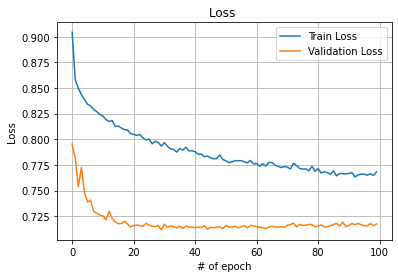

In [9]:
plot_loss_curves(train_loss,val_loss)

Final test from best model : avg_iou = 0.5877429191745929, avg_acc = 0.7327646988541333
 Class wise ious getting saved in best_model_4a_IOU_Classwise.csv file


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


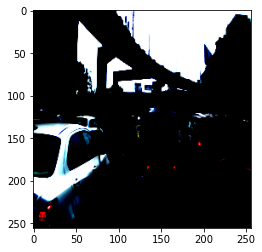

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


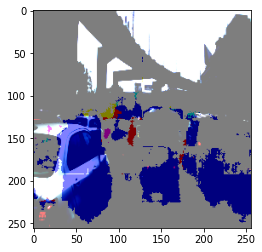

In [11]:
test()